# A COVID-19 Prediction Model Using Symptoms

In [5]:
import pandas as pd
import zipfile
import numpy as np

### The Dataset

The data (sourced [here](https://github.com/nshomron/covidpred)) is from the paper [Machine learning-based prediction of Covid-19 diagnosis based on symptoms](https://www.nature.com/articles/s41746-020-00372-6.pdf)

# Exploratory Data Analysis

### Part 1: Load Data, Data Analysis and Processing

In [6]:
zf = zipfile.ZipFile("data/corona_tested_individuals_ver_00220.english.zip")

df = pd.read_csv(zf.open("corona_tested_individuals_ver_00220.english.csv"),low_memory=False)

In [8]:
# zf_smaller = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/corona_tested_individuals_ver_0083.english.zip")
# df_smaller = pd.read_csv((zf.open("/data/corona_tested_individuals_ver_0083.csv"), low_memory=False)

In [9]:
#pip install pandas-profiling==2.7.1

In [10]:
#!pip install pandas-profiling[notebook]

In [11]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2022-01-30,0,0,0,0,0,positive,No,female,Other
1,2022-01-30,0,0,0,0,0,positive,No,female,Other
2,2022-01-30,0,0,0,0,0,positive,No,male,Other
3,2022-01-30,0,0,0,0,0,positive,No,female,Other
4,2022-01-30,0,0,0,0,0,positive,No,female,Other


In [12]:
# from pandas_profiling import ProfileReport
# #Generate the report

# profile = ProfileReport(df)
# profile

In [13]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    df = df.drop("test_date", axis=1)

    df["corona_result"] = df["corona_result"].map({"negative": 0, "positive": 1, "other": np.nan})
    df = df.dropna()
    df["age_60_and_above"] = df["age_60_and_above"].map({"No": 0, "Yes": 1})
    df["gender"] = df["gender"].map({"female": 1, "male": 0})

    df = pd.get_dummies(df)

    df = df.rename(columns={"test_indication_Contact with confirmed": "contact_with_confirmed", "test_indication_Abroad": "abroad", "test_indication_Other": "other"})

    y = df["corona_result"]
    X = df.drop("corona_result", axis=1)

    return X, y

def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

    return X_train, X_test, y_train, y_test

In [14]:
df["corona_result"].value_counts()

negative    7856225
positive     800109
other        233967
Name: corona_result, dtype: int64

Split the data into `X_train`, `X_test`, `y_train`, `y_test` to prepare for training the model.

In [15]:
X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = split_data(X,y)

In [48]:
# %%time
# train = X_train.copy()
# train['corona_result'] = y_train.copy()

# test = X_test.copy()
# test['corona_result'] = y_test.copy()

# import sweetviz
# my_report = sweetviz.compare([train, "Train"], [test, "Test"], "corona_result")
# my_report.show_html()

# Modelling

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import Image
import pydotplus
import sklearn.tree as tree
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
import shap
from imblearn.under_sampling import RandomUnderSampler

def lgbm_classifier(X_train, X_test, y_train, y_test):

    # define undersample strategy
    undersample = RandomUnderSampler(sampling_strategy='majority')

    # fit and apply the transform
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
    
    model = "LightGBM"
    params = {
        'num_leaves': 15,
        'min_child_samples': 10,
        'max_depth': 5,
        'metric': 'auc'
             }
    lgbm = lgb.LGBMClassifier(**params)
    # fit model
    lgbm.fit(X_train, y_train)
    
    # assess results
    y_pred = lgbm.predict(X_test)
    
    print(f"{model} Classification Report:")
    print()
    print(classification_report(y_test, y_pred))
    
    lgbm_confusion_matrix = confusion_matrix(y_pred, y_test)
    
    print(f'{model} confusion matrix:')
    sns.heatmap(lgbm_confusion_matrix/np.sum(lgbm_confusion_matrix), annot=True, 
                fmt='.2%', cmap='Blues')
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

    auc = roc_auc_score(y_test, y_pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
    plt.title(f'AUC: {auc}')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    plt.show()
    
    print(f'{model} SHAP Feature Importances:')
    fig = plt.figure()
    shap_values = shap.TreeExplainer(lgbm).shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type = 'bar')
    plt.show()

    return lgbm

LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92    581369
         1.0       0.38      0.46      0.42     75319

    accuracy                           0.85    656688
   macro avg       0.66      0.68      0.67    656688
weighted avg       0.87      0.85      0.86    656688

LightGBM confusion matrix:


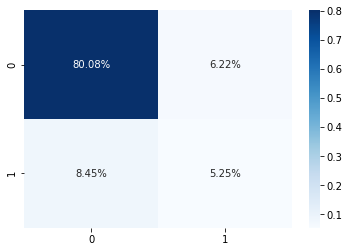

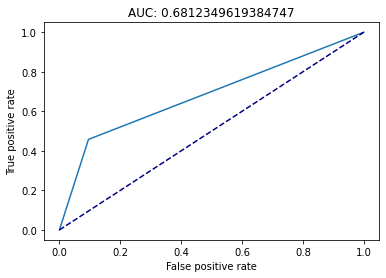

LightGBM SHAP Feature Importances:


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


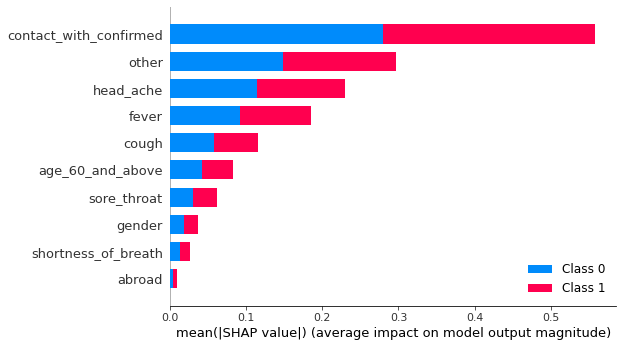

CPU times: user 9min 15s, sys: 11.3 s, total: 9min 26s
Wall time: 2min 15s


LGBMClassifier(max_depth=5, metric='auc', min_child_samples=10, num_leaves=15)

In [46]:
%%time
lgbm_classifier(X_train, X_test, y_train, y_test)

In [64]:
def decision_tree(X_train, X_test, y_train, y_test):

    dtc = DecisionTreeClassifier(random_state=42, class_weight={0:1, 1:10})
    dtc.fit(X_train, y_train)

    dtc_y_pred = dtc.predict(X_test)

    print(classification_report(y_test, dtc_y_pred))

    dt_cm = confusion_matrix(dtc_y_pred, y_test)
    print('Decision Tree confusion matrix:')
    sns.heatmap(dt_cm/np.sum(dt_cm), annot=True, 
                fmt='.2%', cmap='Blues')

    fpr, tpr, thresholds = roc_curve(y_test, dtc_y_pred, pos_label=1)

    auc = roc_auc_score(y_test, dtc_y_pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
    plt.title(f'AUC: {auc}')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

    dt_feature_names = list(X.columns)
    dt_target_names = [str(s) for s in y.unique()]
    tree.export_graphviz(dtc, out_file='tree.dot', 
        feature_names=dt_feature_names, class_names=dt_target_names,
        filled=True, max_depth = 4)  
    graph = pydotplus.graph_from_dot_file('tree.dot')
    Image(graph.create_png())

    return dtc

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92    581369
         1.0       0.38      0.46      0.42     75319

    accuracy                           0.85    656688
   macro avg       0.66      0.68      0.67    656688
weighted avg       0.87      0.85      0.86    656688

Decision Tree confusion matrix:


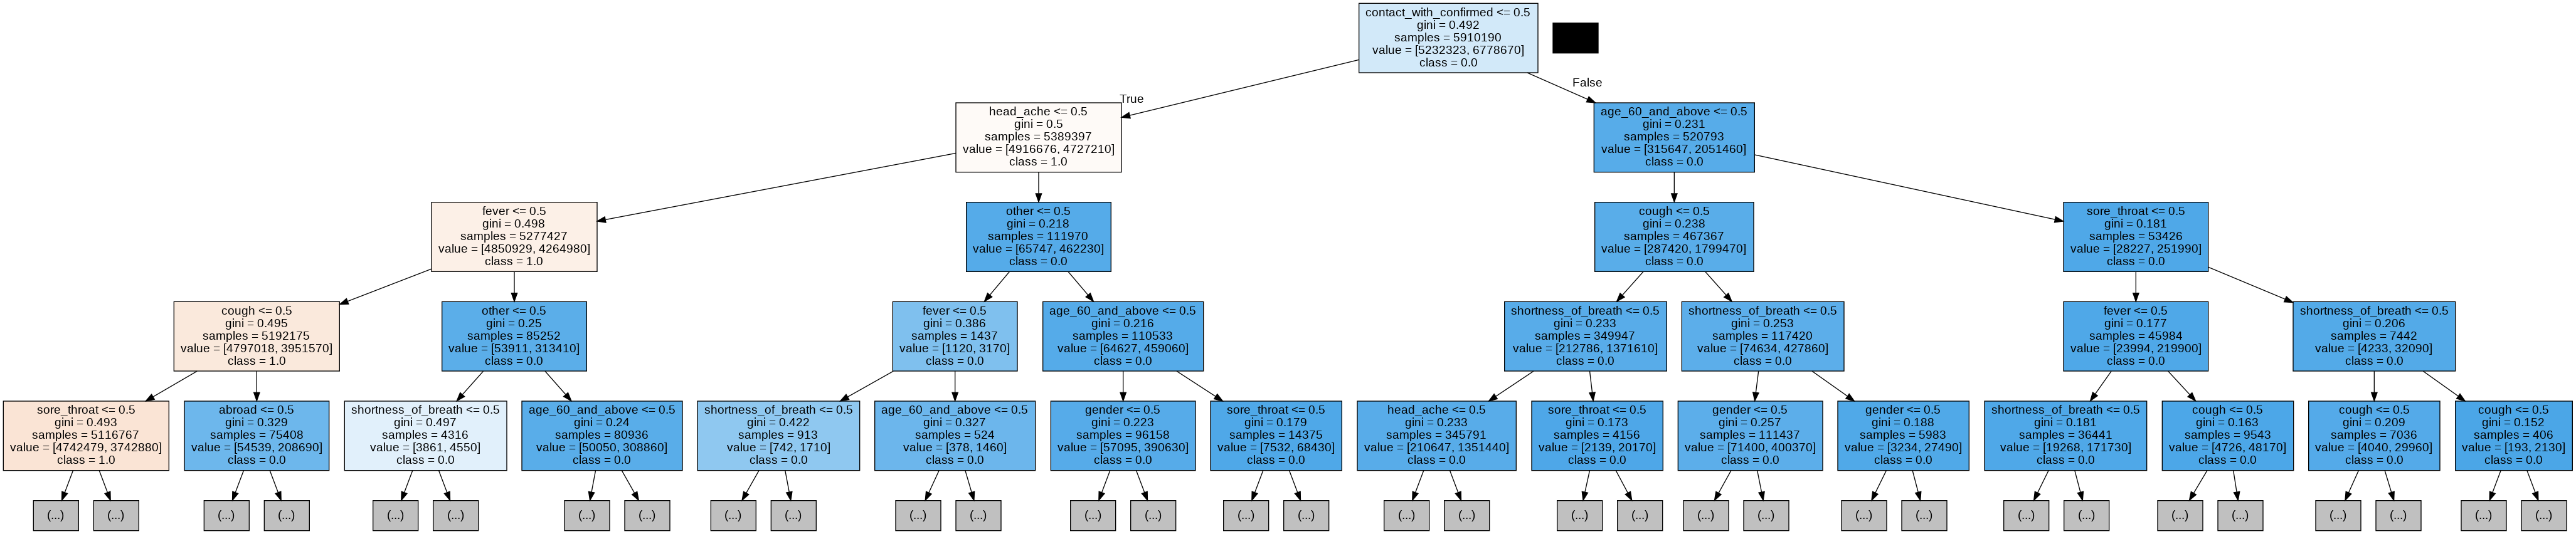

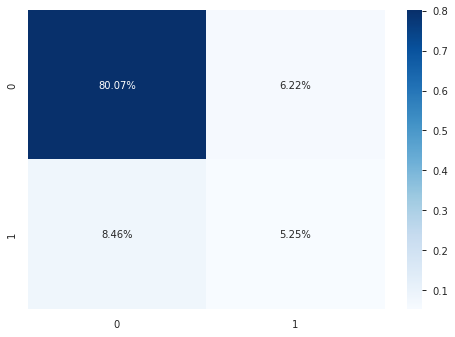

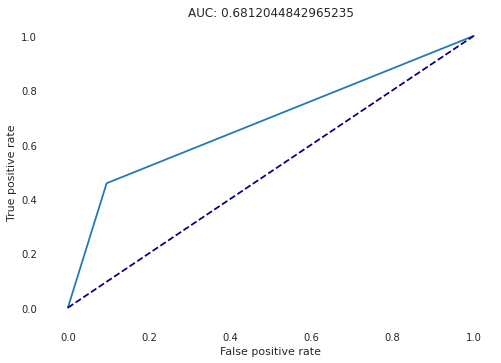

In [69]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

dtc = decision_tree(X_train, X_test, y_train, y_test)

dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in y.unique()]
tree.export_graphviz(dtc, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True, max_depth = 4)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [ ]:
## Extra model 

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

ovo = OneVsOneClassifier(estimator=LinearSVC(max_iter=2000))

#Your code and thoughts below

ovo.fit(X_train, y_train)

ovo_pred = ovo.predict(X_test)

print('OVO performance:')
print(classification_report(y_test, ovo_pred))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, ovo_pred, pos_label=1)

auc = roc_auc_score(y_test, ovo_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')